# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will train your CNN-RNN model.  

You are welcome and encouraged to try out many different architectures and hyperparameters when searching for a good model.

This does have the potential to make the project quite messy!  Before submitting your project, make sure that you clean up:
- the code you write in this notebook.  The notebook should describe how to train a single CNN-RNN architecture, corresponding to your final choice of hyperparameters.  You should structure the notebook so that the reviewer can replicate your results by running the code in this notebook.  
- the output of the code cell in **Step 2**.  The output should show the output obtained when training the model from scratch.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Training Setup
- [Step 2](#step2): Train your Model
- [Step 3](#step3): (Optional) Validate your Model

<a id='step1'></a>
## Step 1: Training Setup

In this step of the notebook, you will customize the training of your CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure.  The values you set now will be used when training your model in **Step 2** below.

You should only amend blocks of code that are preceded by a `TODO` statement.  **Any code blocks that are not preceded by a `TODO` statement should not be modified**.

### Task #1

Begin by setting the following variables:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend that you set `num_epochs=3`, but feel free to increase or decrease this number as you wish.  [This paper](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but you'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if you want your model to compete with current research, you will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend that you set `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that you **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  You are encouraged to keep this at its default value of `100` to avoid clogging the notebook, but feel free to change it.
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

If you're not sure where to begin to set some of the values above, you can peruse [this paper](https://arxiv.org/pdf/1502.03044.pdf) and [this paper](https://arxiv.org/pdf/1411.4555.pdf) for useful guidance!  **To avoid spending too long on this notebook**, you are encouraged to consult these suggested research papers to obtain a strong initial guess for which hyperparameters are likely to work best.  Then, train a single model, and proceed to the next notebook (**3_Inference.ipynb**).  If you are unhappy with your performance, you can return to this notebook to tweak the hyperparameters (and/or the architecture in **model.py**) and re-train your model.

### Question 1

**Question:** Describe your CNN-RNN architecture in detail.  With this architecture in mind, how did you select the values of the variables in Task 1?  If you consulted a research paper detailing a successful implementation of an image captioning model, please provide the reference.

**Answer:** 


### (Optional) Task #2

Note that we have provided a recommended image transform `transform_train` for pre-processing the training images, but you are welcome (and encouraged!) to modify it as you wish.  When modifying this transform, keep in mind that:
- the images in the dataset have varying heights and widths, and 
- if using a pre-trained model, you must perform the corresponding appropriate normalization.

### Question 2

**Question:** How did you select the transform in `transform_train`?  If you left the transform at its provided value, why do you think that it is a good choice for your CNN architecture?

**Answer:** 

### Task #3

Next, you will specify a Python list containing the learnable parameters of the model.  For instance, if you decide to make all weights in the decoder trainable, but only want to train the weights in the embedding layer of the encoder, then you should set `params` to something like:
```
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 
```

### Question 3

**Question:** How did you select the trainable parameters of your architecture?  Why do you think this is a good choice?

**Answer:** 

### Task #4

Finally, you will select an [optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Optimizer).

### Question 4

**Question:** How did you select the optimizer used to train your model?

**Answer:** 

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math

%reload_ext autoreload
%autoreload 2
from model import EncoderCNN, DecoderRNN

## TODO #1: Select appropriate values for the Python variables below.
batch_size = 128          # batch size
vocab_threshold = 4        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity
learning_rate = 1e-3

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(encoder.embed.parameters()) + list(decoder.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=learning_rate)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...




  0%|          | 0/414113 [00:00<?, ?it/s]

  0%|          | 420/414113 [00:00<01:38, 4196.53it/s]

  0%|          | 981/414113 [00:00<01:31, 4537.87it/s]

  0%|          | 1559/414113 [00:00<01:25, 4848.74it/s]

  1%|          | 2138/414113 [00:00<01:20, 5095.59it/s]

  1%|          | 2725/414113 [00:00<01:17, 5304.11it/s]

  1%|          | 3312/414113 [00:00<01:15, 5460.55it/s]

  1%|          | 3905/414113 [00:00<01:13, 5591.57it/s]

  1%|          | 4506/414113 [00:00<01:11, 5710.18it/s]

  1%|          | 5117/414113 [00:00<01:10, 5822.71it/s]

  1%|▏         | 5687/414113 [00:01<01:12, 5599.94it/s]

  2%|▏         | 6254/414113 [00:01<01:12, 5619.86it/s]

  2%|▏         | 6835/414113 [00:01<01:11, 5673.29it/s]

  2%|▏         | 7421/414113 [00:01<01:11, 5726.97it/s]

  2%|▏         | 8024/414113 [00:01<01:09, 5813.37it/s]

  2%|▏         | 8626/414113 [00:01<01:09, 5871.97it/s]

  2%|▏         | 9213/414113 [00:01<01:09, 5864.42it/s]

  2%|▏         | 9799/414113 [00:01<01:09, 5

Done (t=0.87s)
creating index...
index created!
Obtaining caption lengths...


<a id='step2'></a>
## Step 2: Train your Model

Once you have executed the code cell in **Step 1**, the training procedure below should run without issue.  

It is completely fine to leave the code cell below as-is without modifications to train your model.  However, if you would like to modify the code used to train the model below, you must ensure that your changes are easily parsed by your reviewer.  In other words, make sure to provide appropriate comments to describe how your code works!  

You may find it useful to load saved weights to resume training.  In that case, note the names of the files containing the encoder and decoder weights that you'd like to load (`encoder_file` and `decoder_file`).  Then you can load the weights by using the lines below:

```python
# Load pre-trained weights before resuming training.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))
```

While trying out parameters, make sure to take extensive notes and record the settings that you used in your various training runs.  In particular, you don't want to encounter a situation where you've trained a model for several hours but can't remember what settings you used :).

### A Note on Tuning Hyperparameters

To figure out how well your model is doing, you can look at how the training loss and perplexity evolve during training - and for the purposes of this project, you are encouraged to amend the hyperparameters based on this information.  

However, this will not tell you if your model is overfitting to the training data, and, unfortunately, overfitting is a problem that is commonly encountered when training image captioning models.  

For this project, you need not worry about overfitting. **This project does not have strict requirements regarding the performance of your model**, and you just need to demonstrate that your model has learned **_something_** when you generate captions on the test data.  For now, we strongly encourage you to train your model for the suggested 3 epochs without worrying about performance; then, you should immediately transition to the next notebook in the sequence (**3_Inference.ipynb**) to see how your model performs on the test data.  If your model needs to be changed, you can come back to this notebook, amend hyperparameters (if necessary), and re-train the model.

That said, if you would like to go above and beyond in this project, you can read about some approaches to minimizing overfitting in section 4.3.1 of [this paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7505636).  In the next (optional) step of this notebook, we provide some guidance for assessing the performance on the validation dataset.

In [6]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time
from datetime import datetime

# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()
response = requests.request("GET", 
                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            headers={"Metadata-Flavor":"Google"})

t_start = datetime.now()

for epoch in range(1, num_epochs+1):
    t_epoch_start = datetime.now()
    
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
            requests.request("POST", 
                             "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             headers={'Authorization': "STAR " + response.text})
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

    t_epoch_end = datetime.now()
    print('\n\n--**--')
    print('Time elasped in epoch {}: {}'.format(epoch, (t_epoch_end - t_epoch_start)))
    
t_end = datetime.now()
print('\n\n--**--')
print('Time elasped in {} epochs: {}'.format(num_epochs, (t_end - t_start)))
print('Average Time per epoch: {}'.format((t_end - t_start) / num_epochs))

# Close the training log file.
f.close()

Epoch [1/3], Step [100/3236], Loss: 3.7700, Perplexity: 43.3804
Epoch [1/3], Step [200/3236], Loss: 3.3820, Perplexity: 29.4300
Epoch [1/3], Step [300/3236], Loss: 3.1434, Perplexity: 23.1830
Epoch [1/3], Step [400/3236], Loss: 3.0646, Perplexity: 21.4265
Epoch [1/3], Step [500/3236], Loss: 3.0873, Perplexity: 21.9169
Epoch [1/3], Step [600/3236], Loss: 2.8680, Perplexity: 17.6024
Epoch [1/3], Step [700/3236], Loss: 3.9130, Perplexity: 50.0511
Epoch [1/3], Step [800/3236], Loss: 3.5533, Perplexity: 34.9277
Epoch [1/3], Step [900/3236], Loss: 2.6887, Perplexity: 14.7120
Epoch [1/3], Step [1000/3236], Loss: 2.5712, Perplexity: 13.0813
Epoch [1/3], Step [1100/3236], Loss: 2.5506, Perplexity: 12.8150
Epoch [1/3], Step [1200/3236], Loss: 2.6276, Perplexity: 13.8404
Epoch [1/3], Step [1300/3236], Loss: 2.5513, Perplexity: 12.8239
Epoch [1/3], Step [1400/3236], Loss: 2.4319, Perplexity: 11.3799
Epoch [1/3], Step [1500/3236], Loss: 2.4364, Perplexity: 11.4321
Epoch [1/3], Step [1600/3236], Los

<a id='step3'></a>
## Step 3: (Optional) Validate your Model

To assess potential overfitting, one approach is to assess performance on a validation set.  If you decide to do this **optional** task, you are required to first complete all of the steps in the next notebook in the sequence (**3_Inference.ipynb**); as part of that notebook, you will write and test code (specifically, the `sample` method in the `DecoderRNN` class) that uses your RNN decoder to generate captions.  That code will prove incredibly useful here. 

If you decide to validate your model, please do not edit the data loader in **data_loader.py**.  Instead, create a new file named **data_loader_val.py** containing the code for obtaining the data loader for the validation data.  You can access:
- the validation images at filepath `'/opt/cocoapi/images/train2014/'`, and
- the validation image caption annotation file at filepath `'/opt/cocoapi/annotations/captions_val2014.json'`.

The suggested approach to validating your model involves creating a json file such as [this one](https://github.com/cocodataset/cocoapi/blob/master/results/captions_val2014_fakecap_results.json) containing your model's predicted captions for the validation images.  Then, you can write your own script or use one that you [find online](https://github.com/tylin/coco-caption) to calculate the BLEU score of your model.  You can read more about the BLEU score, along with other evaluation metrics (such as TEOR and Cider) in section 4.1 of [this paper](https://arxiv.org/pdf/1411.4555.pdf).  For more information about how to use the annotation file, check out the [website](http://cocodataset.org/#download) for the COCO dataset.

#### Step 3-1: Import COCO

In [5]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
cocoapi_loc='/opt'
# sys.path.append('/home/workspace/private_coco_lib/cocoapi/PythonAPI')
# cocoapi_loc='./annotations_valid_dataset/'
import pycocotools
from pycocotools.coco import COCO

#### Step 3-2: Create Valid Dataset DataLoader

In [18]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

from data_loader_val import get_loader_valid
from torchvision import transforms

transform_valid = transforms.Compose([
                transforms.Resize(224),
                transforms.RandomCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                                     (0.229, 0.224, 0.225))
                ])

data_loader = get_loader_valid(transform=transform_valid,
                              mode='valid',
                              cocoapi_loc=cocoapi_loc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


#### Step 3-3: Restore encoder and decoder

In [15]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
import os
import torch
from model import EncoderCNN, DecoderRNN

# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

embed_size = 512
hidden_size = 512

vocab_size = len(data_loader.dataset.vocab)

encoder = EncoderCNN(embed_size)
encoder.eval()

decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 113176752.23it/s]


DecoderRNN(
  (embed): Embedding(9955, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (fc_out): Linear(in_features=512, out_features=9955, bias=True)
)

#### Step 3-4: Get Captions from Valid DataLoader

In [73]:
def clean_sentence(output):
    
    end_word_idx = data_loader.dataset.vocab.word2idx[data_loader.dataset.vocab.end_word]
    start_word_idx = data_loader.dataset.vocab.word2idx[data_loader.dataset.vocab.start_word]
    period_idx = data_loader.dataset.vocab.word2idx['.']
    
    sentence = ''
    prev_c = start_word_idx
    
    for c in output:
        if c == end_word_idx:
            break
        elif c == start_word_idx:
            prev_c = c
            pass
        elif c == period_idx:
            sentence += '.'
        else:
            if prev_c == start_word_idx:
                sentence = data_loader.dataset.vocab.idx2word[c]
            else:
                sentence = sentence + ' ' + data_loader.dataset.vocab.idx2word[c]
          
        prev_c = c
        
    sentence = sentence.capitalize()
    return sentence

In [84]:
from datetime import datetime 
from tqdm import tqdm

counter = 0
total_images = len(data_loader.dataset.imgIds)

captions_results = []

t_start = datetime.now()

for img, imgId in (iter(data_loader)):
        
    img = img.to(device)
   
    features = encoder(img).unsqueeze(1)
    output = decoder.sample(features)
    
    caption = clean_sentence(output)

    result = {'image_id': imgId.item(), 'caption': caption}
    captions_results.append(result)
    
    counter += 1
    
    if counter % 1000 == 0:
        print('progress: {}/{}'.format(counter, total_images))
        print('Time Elapsed: {}'.format(datetime.now() - t_start))
    
t_end = datetime.now()

print('Image numbers: {}'.format(counter))
print('Time Elapsed: {}'.format(t_end - t_start))
print('Time per Image: {}'.format((t_end-t_start)/(counter)))

progress: 1000/40504
Time Elapsed: 0:00:42.402528


KeyboardInterrupt: 

In [85]:
import json

with open('./annotations_valid_dataset/captions_val2014_results', 'w') as f:
    json.dump(captions_results, f)

#### Step 3-5: Load JSON Result and Captions from CoCo

In [1]:
# prefect match
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'small', 'test', 'b']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25])
print(score)

0.5506953149031837


/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [2]:
from nltk.translate.bleu_score import corpus_bleu
references = [[['this', 'is', 'small', 'test', 'b']]]
candidates = [['this', 'is', 'a', 'test']]
score = corpus_bleu(references, candidates)
print(score)

0.5506953149031837


/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [4]:
import numpy as np
p =  np.exp(1/4 * (np.log(3/4) + np.log(1/3)) )
BP = np.exp(1- min(1, len(reference[0]) / len(candidate)))
print(BP)
combined_score = BP * p
print(combined_score)

1.0
0.707106781187


In [2]:
import json

r = [{"image_id": 391895, "caption": "Man riding a motor bike on a dirt road on the countryside."}, {"image_id": 522418, "caption": "A woman wearing a net on her head cutting a cake. "}, {"image_id": 184613, "caption": "a young boy barefoot holding an umbrella touching the horn of a cow"}]
print(type(r))
print(type(r[0]))
r_json = json.dumps(r)
print(type(r_json))

with open('./annotations_valid_dataset/generated_valid_annotations.json', 'w') as f:
    json.dump(r, f)

<class 'list'>
<class 'dict'>
<class 'str'>


In [1]:
import sys
sys.path.append('/home/workspace/private_coco_lib/cocoapi/PythonAPI')
import pycocotools
from pycocotools.coco import COCO

In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [3]:
annFile='./annotations_valid_dataset/coco/annotations/captions_val2014.json'
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


In [4]:
# imgIds = coco.getImgIds()[0]
imgIds = 324158
img = coco.loadImgs(imgIds)[0]
print(len(list(coco.imgs.keys())))

40504


In [28]:
print(img)
print(img['coco_url'])
print(img['file_name'])

{'license': 1, 'file_name': 'COCO_val2014_000000324158.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000324158.jpg', 'height': 334, 'width': 500, 'date_captured': '2013-11-19 23:54:06', 'flickr_url': 'http://farm1.staticflickr.com/169/417836491_5bf8762150_z.jpg', 'id': 324158}
http://images.cocodataset.org/val2014/COCO_val2014_000000324158.jpg
COCO_val2014_000000324158.jpg


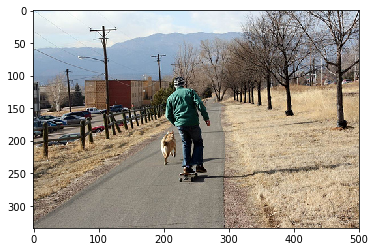

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io as io

I = io.imread(img['coco_url'])
plt.imshow(I)

In [7]:
annIds = coco.getAnnIds(imgIds=imgIds)
print(annIds)

[310079, 311105, 311588, 312677, 312860]


In [8]:
anns = coco.loadAnns(annIds)
print(anns)
print('-----')
coco.showAnns(anns)

[{'image_id': 324158, 'id': 310079, 'caption': 'A man is skate boarding down a path and a dog is running by his side.'}, {'image_id': 324158, 'id': 311105, 'caption': 'A man on a skateboard with a dog outside. '}, {'image_id': 324158, 'id': 311588, 'caption': 'A person riding a skate board with a dog following beside.'}, {'image_id': 324158, 'id': 312677, 'caption': 'This man is riding a skateboard behind a dog.'}, {'image_id': 324158, 'id': 312860, 'caption': 'A man walking his dog on a quiet country road.'}]
-----
A man is skate boarding down a path and a dog is running by his side.
A man on a skateboard with a dog outside. 
A person riding a skate board with a dog following beside.
This man is riding a skateboard behind a dog.
A man walking his dog on a quiet country road.


In [13]:
coco.anns

{37: {'image_id': 203564,
  'id': 37,
  'caption': 'A bicycle replica with a clock as the front wheel.'},
 38: {'image_id': 179765,
  'id': 38,
  'caption': 'A black Honda motorcycle parked in front of a garage.'},
 49: {'image_id': 322141,
  'id': 49,
  'caption': 'A room with blue walls and a white sink and door.'},
 89: {'image_id': 16977,
  'id': 89,
  'caption': 'A car that seems to be parked illegally behind a legally parked car'},
 98: {'image_id': 106140,
  'id': 98,
  'caption': 'A large passenger airplane flying through the air.'},
 101: {'image_id': 106140,
  'id': 101,
  'caption': 'There is a GOL plane taking off in a partly cloudy sky.'},
 109: {'image_id': 322141,
  'id': 109,
  'caption': 'Blue and white color scheme in a small bathroom.'},
 121: {'image_id': 322141,
  'id': 121,
  'caption': 'This is a blue and white bathroom with a wall sink and a lifesaver on the wall.'},
 163: {'image_id': 322141,
  'id': 163,
  'caption': 'A blue boat themed bathroom with a life pr

In [21]:
import nltk
nltk.download('punkt')
caption = str(coco.anns[49]['caption']).lower()
nltk.tokenize.word_tokenize(caption)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['a',
 'room',
 'with',
 'blue',
 'walls',
 'and',
 'a',
 'white',
 'sink',
 'and',
 'door',
 '.']

In [6]:
import json

annotation_file='./annotations_valid_dataset/captions_val2014.json'
caption_valid = json.loads(open(annotation_file).read())

In [9]:
caption_valid['info']

{'description': 'COCO 2014 Dataset',
 'url': 'http://cocodataset.org',
 'version': '1.0',
 'year': 2014,
 'contributor': 'COCO Consortium',
 'date_created': '2017/09/01'}

In [11]:
caption_valid['images']

[{'license': 3,
  'file_name': 'COCO_val2014_000000391895.jpg',
  'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg',
  'height': 360,
  'width': 640,
  'date_captured': '2013-11-14 11:18:45',
  'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
  'id': 391895},
 {'license': 4,
  'file_name': 'COCO_val2014_000000522418.jpg',
  'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000522418.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-14 11:38:44',
  'flickr_url': 'http://farm1.staticflickr.com/1/127244861_ab0c0381e7_z.jpg',
  'id': 522418},
 {'license': 3,
  'file_name': 'COCO_val2014_000000184613.jpg',
  'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000184613.jpg',
  'height': 336,
  'width': 500,
  'date_captured': '2013-11-14 12:36:29',
  'flickr_url': 'http://farm3.staticflickr.com/2169/2118578392_1193aa04a0_z.jpg',
  'id': 184613},
 {'license': 3,
  'file_name': 'COC

In [12]:
caption_valid['annotations']

dict_keys(['info', 'images', 'licenses', 'annotations'])